## Fit autocovariance

Objective : Estimate tides paramters by fitting a model to Eulerian and Lagrangian binned covariance of the demodulated velocity field

Several parameters of the fitting method can be testing.
Here we focus on a least-square method.

1) Basic method :

Model : $\tilde V e^{-\tau/\tilde T}cos(\omega\tau)$ ; with $\tilde V$ the variance, $\tilde T$ the incoherence timescale and $\omega = \frac{\omega_{S2}-\omega_{M2}}{2}$ fixed the spring neap cycle frequency over 2 (oscilations caused by demodulation)

No bounds, no first guess for the estimates, same weight at all timelag

2) Bounds imposed

3) More weight on the shortest timelags (20days) and a lot on the first. First guess for $\tilde V$ fixed at the autocovariance at timelag 0

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr
import scipy.optimize
#import mitequinox.sigp as sp

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

from inspect import signature
import scipy

In [2]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [3]:
omega_sn = (omega_S2-omega_M2)/2

print('Spring-neap cycle : ', 1/(2*omega_sn), 'days')
print('Oscillation after demodulation ( spring-neap cycle /2): ', 1/omega_sn, 'days')

Spring-neap cycle :  14.765294045749723 days
Oscillation after demodulation ( spring-neap cycle /2):  29.530588091499446 days


In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,**kwargs):
    cbar_kw = {'fraction':0.02}
    if 'label' in kwargs.keys():
        cbar_kw['label'] = kwargs['label']
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bin',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,**kwargs,
           cbar_kwargs=cbar_kw)
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

In [6]:
#root_path = '/home/datawork-lops-osi/equinox/jetn/'
root_path = '/Users/zcaspar/codes/mit4320/'

#Eulerian
dsE_low_mean0 = xr.open_dataset(root_path+'E_low_fit_mean0_v2.nc')
dsE_low_mean1 = xr.open_dataset(root_path+'E_low_fit_mean1.nc')

#Lagrangian
dsL_low_mean0 = xr.open_dataset(root_path+'L_low_fit_mean0_v2.nc')
dsL_low_mean1 = xr.open_dataset(root_path+'L_low_fit_mean1.nc')

In [8]:
dsL_low_mean0

<xarray.Dataset>
Dimensions:         (lat_bin: 59, lon_bin: 179, param: 3, lags: 321)
Coordinates:
  * lat_bin         (lat_bin) float64 -59.0 -57.0 -55.0 -53.0 ... 53.0 55.0 57.0
  * lon_bin         (lon_bin) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * param           (param) object 'T' 'V' 'c'
  * lags            (lags) float64 0.0 0.125 0.25 0.375 ... 39.75 39.88 40.0
Data variables:
    parameters_SSU  (lat_bin, lon_bin, param) float64 ...
    error_SSU       (lat_bin, lon_bin, param) float64 ...
    rr_SSU          (lat_bin, lon_bin, lags) float64 ...
    parameters_SSV  (lat_bin, lon_bin, param) float64 ...
    error_SSV       (lat_bin, lon_bin, param) float64 ...
    rr_SSV          (lat_bin, lon_bin, lags) float64 ...

#### Decorrelation timescale

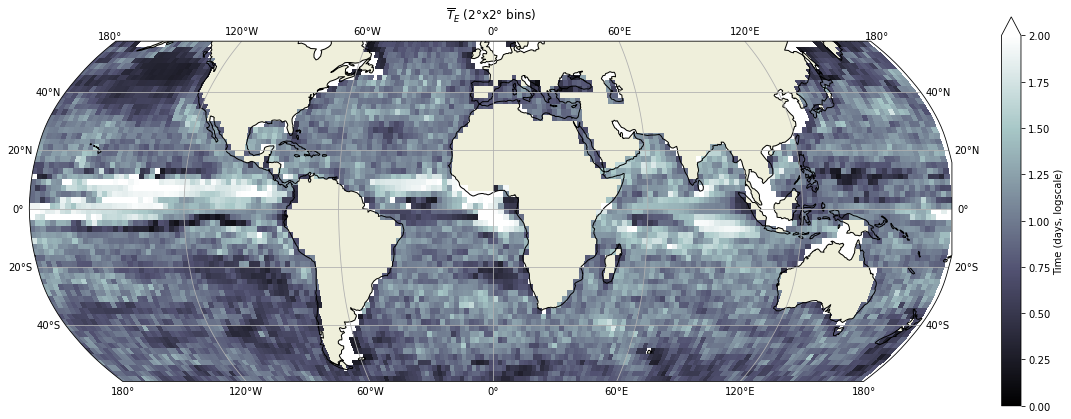

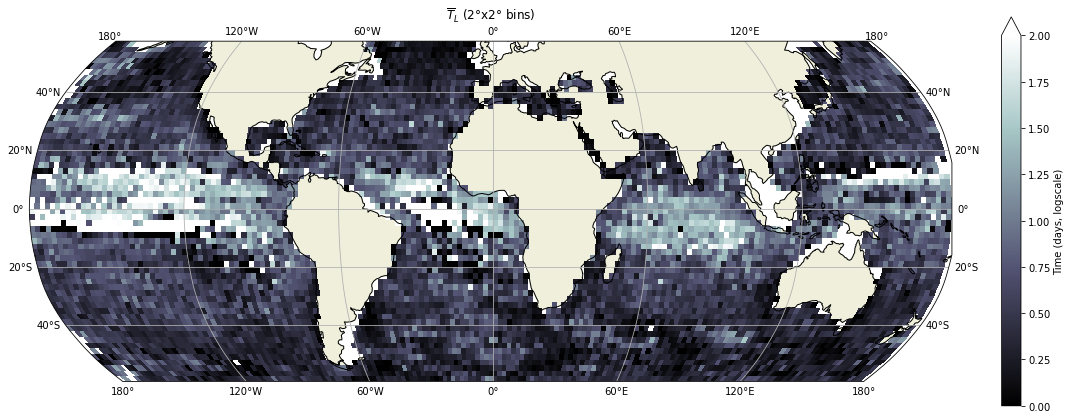

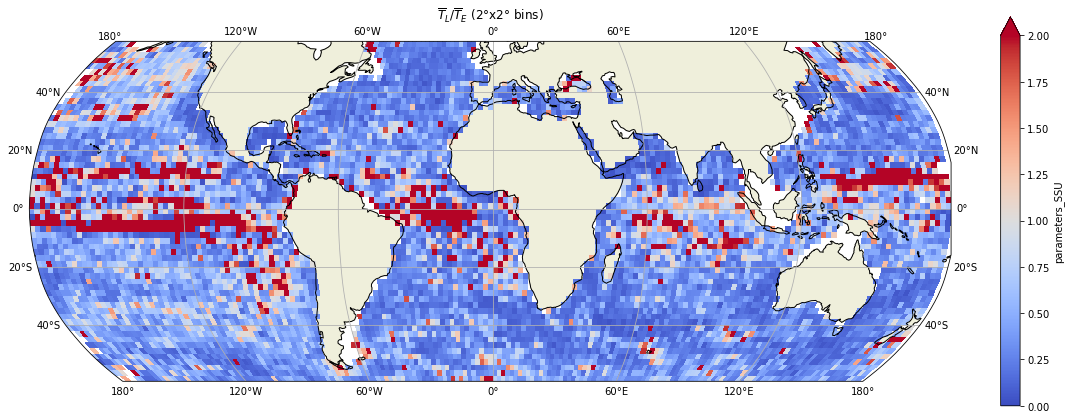

In [13]:
figsize = (15,6)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsE_low_mean0.sel(param = 'T').parameters_SSU),colmap='bone',vlim=(0,2),
                   label='Time (days, logscale)')
ax.set_title(r'$\overline{T}_E$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Tbar_mean1_log.png',bbox_inches="tight")


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsL_low_mean0.sel(param = 'T').parameters_SSU),colmap='bone',vlim=(0,2),
                  label='Time (days, logscale)')
ax.set_title(r'$\overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_Tbar_mean1_log.png',bbox_inches="tight")

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_low_mean0.sel(param = 'T').parameters_SSU/dsE_low_mean0.sel(param = 'T').parameters_SSU,
                   colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$\overline{T}_L/\overline{T}_E$ (2°x2° bins)')
fig.tight_layout()

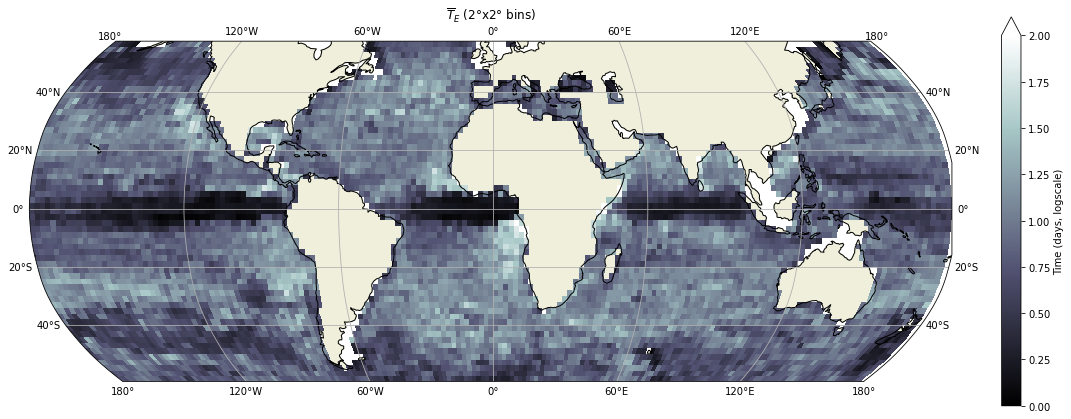

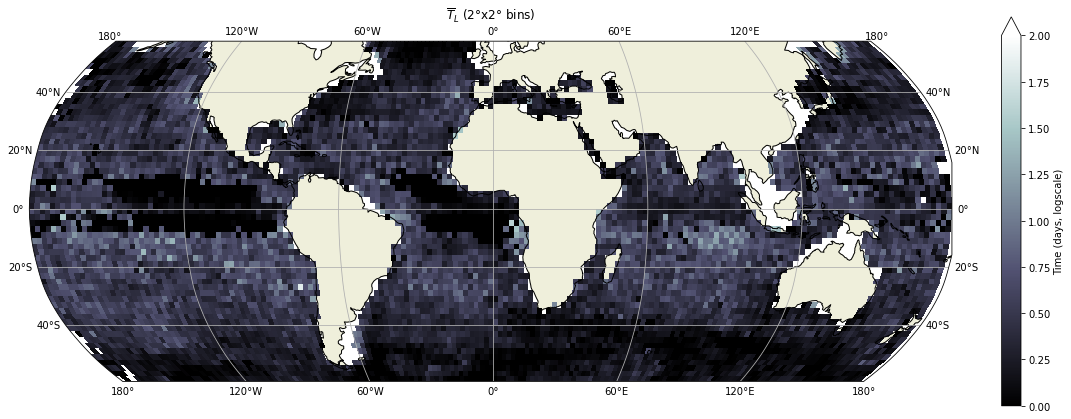

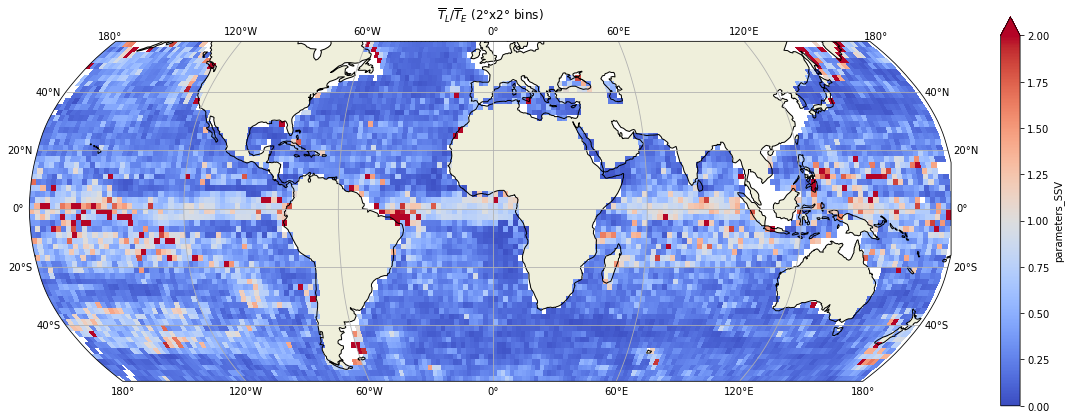

In [14]:
figsize = (15,6)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsE_low_mean0.sel(param = 'T').parameters_SSV),colmap='bone',vlim=(0,2),
                   label='Time (days, logscale)')
ax.set_title(r'$\overline{T}_E$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Tbar_mean1_log.png',bbox_inches="tight")


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsL_low_mean0.sel(param = 'T').parameters_SSV),colmap='bone',vlim=(0,2),
                  label='Time (days, logscale)')
ax.set_title(r'$\overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_Tbar_mean1_log.png',bbox_inches="tight")

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_low_mean0.sel(param = 'T').parameters_SSV/dsE_low_mean0.sel(param = 'T').parameters_SSV,
                   colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$\overline{T}_L/\overline{T}_E$ (2°x2° bins)')
fig.tight_layout()

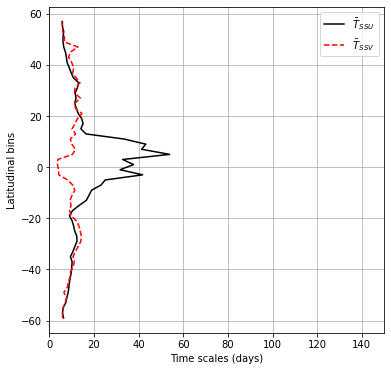

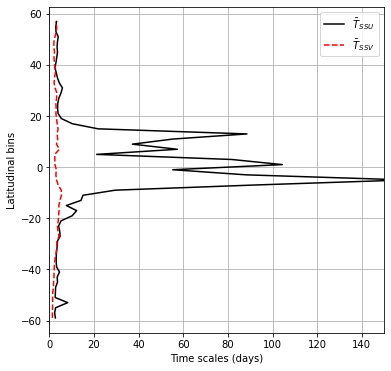

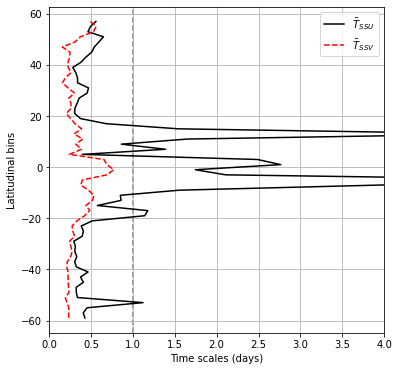

In [17]:
fig,ax = plt.subplots(figsize=(6,6))
dsE_low_mean0.sel(param='T').parameters_SSU.mean('lon_bin').plot(ax=ax,y='lat_bin',label=r'$\bar T_{SSU}$',c='k')
dsE_low_mean0.sel(param='T').parameters_SSV.mean('lon_bin').plot(ax=ax,y='lat_bin',label=r'$\bar T_{SSV}$',
                                                            c='r',linestyle='--')
ax.grid();ax.set_ylabel('Latitudinal bins'); ax.set_xlabel('Time scales (days)');
ax.set_title('');ax.legend();ax.set_xlim(0,150)
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Tbar_lat_mean1.png',bbox_inches="tight")

fig,ax = plt.subplots(figsize=(6,6))
dsL_low_mean0.sel(param='T').parameters_SSU.mean('lon_bin').plot(ax=ax,y='lat_bin',label=r'$\bar T_{SSU}$',c='k')
dsL_low_mean0.sel(param='T').parameters_SSV.mean('lon_bin').plot(ax=ax,y='lat_bin',label=r'$\bar T_{SSV}$',
                                                           c='r',linestyle='--')
ax.grid();ax.set_ylabel('Latitudinal bins'); ax.set_xlabel('Time scales (days)');
ax.set_title('');ax.legend();ax.set_xlim(0,150)
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_Tbar_lat_mean1.png',bbox_inches="tight")

fig,ax = plt.subplots(figsize=(6,6))
(dsL_low_mean0.sel(param='T').parameters_SSU.mean('lon_bin')/dsE_low_mean0.sel(param='T').parameters_SSU.mean('lon_bin')
).plot(ax=ax,y='lat_bin',label=r'$\bar T_{SSU}$',c='k')
(dsL_low_mean0.sel(param='T').parameters_SSV.mean('lon_bin')/dsE_low_mean0.sel(param='T').parameters_SSV.mean('lon_bin')
).plot(ax=ax,y='lat_bin',label=r'$\bar T_{SSV}$',
                                                           c='r',linestyle='--')
ax.grid();ax.set_ylabel('Latitudinal bins'); ax.set_xlabel('Time scales (days)');
ax.set_title('');ax.legend();ax.set_xlim(0,4);ax.axvline(1,c='grey',linestyle='--',zorder=-1)
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/LE_Tbar_lat_mean1.png',bbox_inches="tight")


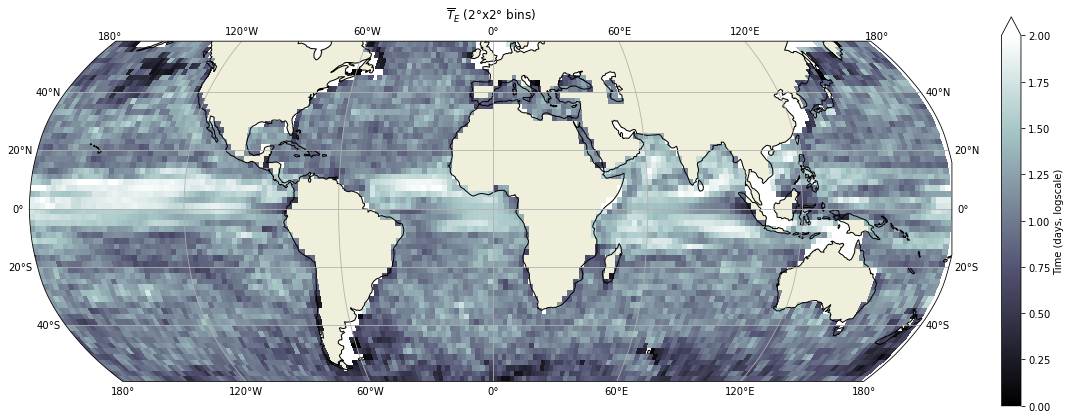

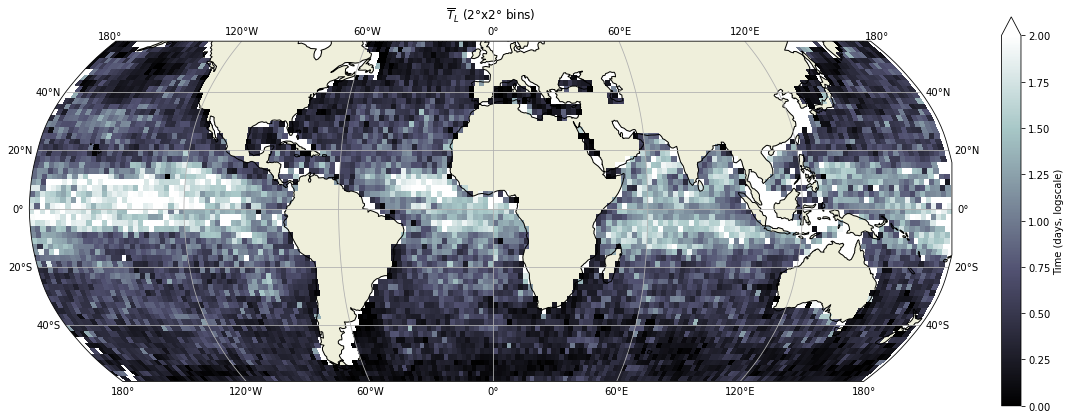

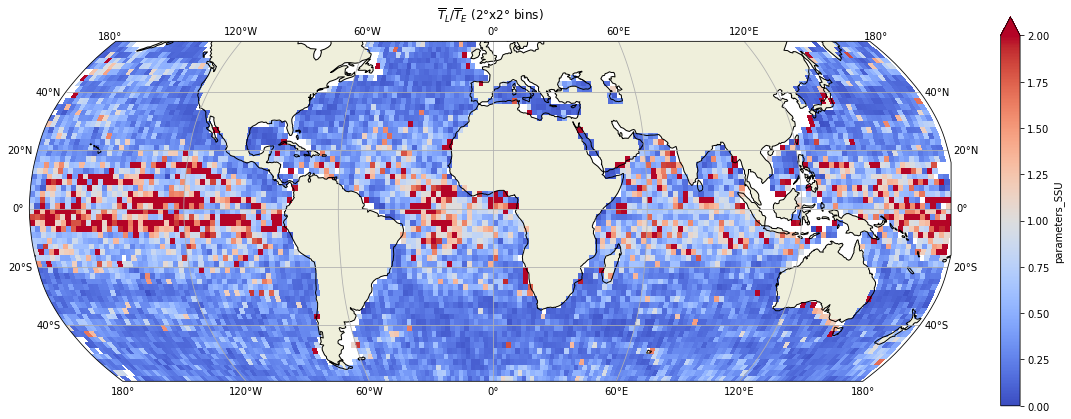

In [18]:

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsE_low_mean1.sel(param = 'T').parameters_SSU),colmap='bone',vlim=(0,2),
                   label='Time (days, logscale)')
ax.set_title(r'$\overline{T}_E$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Tbar_mean1_log.png',bbox_inches="tight")


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsL_low_mean1.sel(param = 'T').parameters_SSU),colmap='bone',vlim=(0,2),
                  label='Time (days, logscale)')
ax.set_title(r'$\overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_Tbar_mean1_log.png',bbox_inches="tight")

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_low_mean1.sel(param = 'T').parameters_SSU/dsE_low_mean1.sel(param = 'T').parameters_SSU,
                   colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$\overline{T}_L/\overline{T}_E$ (2°x2° bins)')
fig.tight_layout()

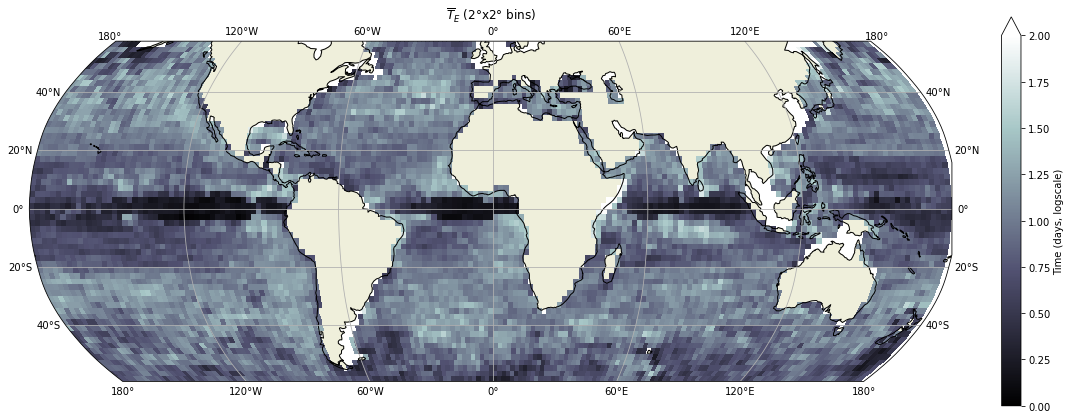

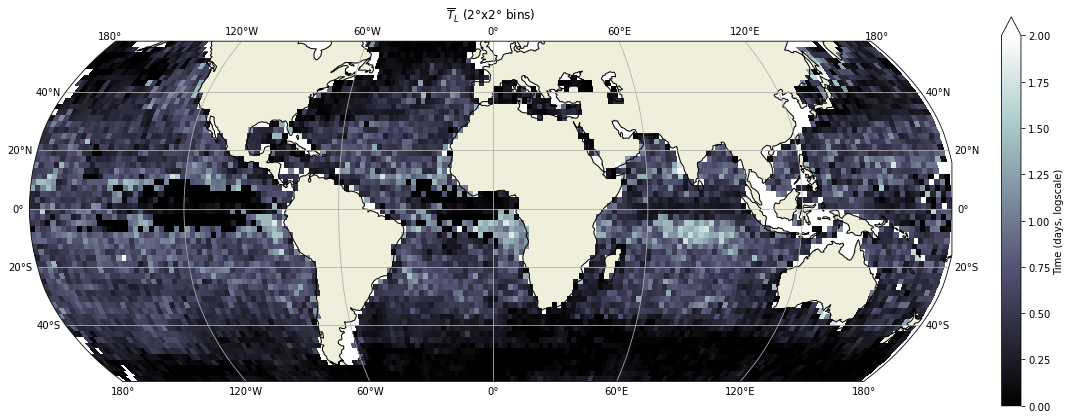

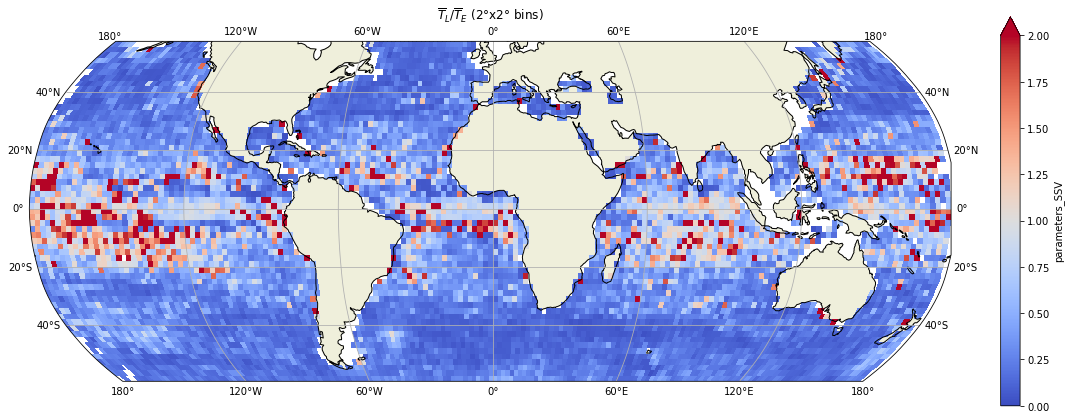

In [19]:
figsize = (15,6)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsE_low_mean1.sel(param = 'T').parameters_SSV),colmap='bone',vlim=(0,2),
                   label='Time (days, logscale)')
ax.set_title(r'$\overline{T}_E$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Tbar_mean1_log.png',bbox_inches="tight")


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsL_low_mean1.sel(param = 'T').parameters_SSV),colmap='bone',vlim=(0,2),
                  label='Time (days, logscale)')
ax.set_title(r'$\overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_Tbar_mean1_log.png',bbox_inches="tight")

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_low_mean1.sel(param = 'T').parameters_SSV/dsE_low_mean1.sel(param = 'T').parameters_SSV,
                   colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$\overline{T}_L/\overline{T}_E$ (2°x2° bins)')
fig.tight_layout()

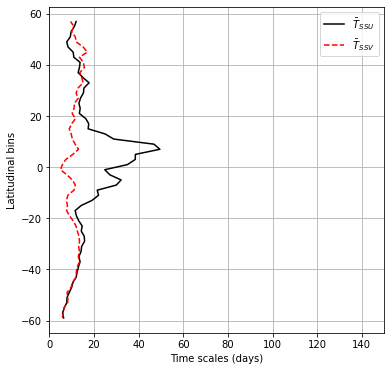

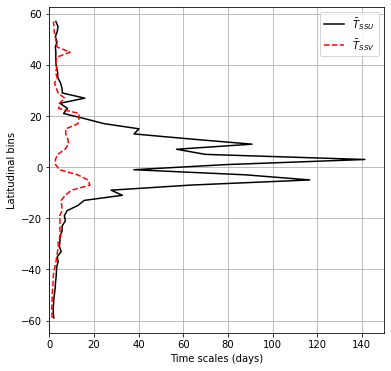

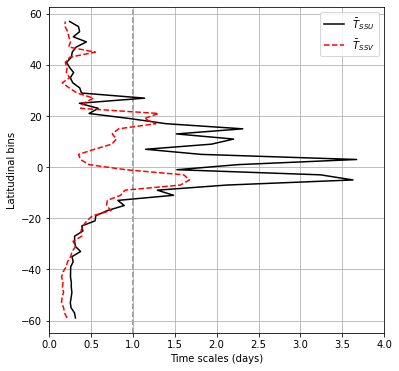

In [20]:
fig,ax = plt.subplots(figsize=(6,6))
dsE_low_mean1.sel(param='T').parameters_SSU.mean('lon_bin').plot(ax=ax,y='lat_bin',label=r'$\bar T_{SSU}$',c='k')
dsE_low_mean1.sel(param='T').parameters_SSV.mean('lon_bin').plot(ax=ax,y='lat_bin',label=r'$\bar T_{SSV}$',
                                                            c='r',linestyle='--')
ax.grid();ax.set_ylabel('Latitudinal bins'); ax.set_xlabel('Time scales (days)');
ax.set_title('');ax.legend();ax.set_xlim(0,150)
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Tbar_lat_mean1.png',bbox_inches="tight")

fig,ax = plt.subplots(figsize=(6,6))
dsL_low_mean1.sel(param='T').parameters_SSU.mean('lon_bin').plot(ax=ax,y='lat_bin',label=r'$\bar T_{SSU}$',c='k')
dsL_low_mean1.sel(param='T').parameters_SSV.mean('lon_bin').plot(ax=ax,y='lat_bin',label=r'$\bar T_{SSV}$',
                                                           c='r',linestyle='--')
ax.grid();ax.set_ylabel('Latitudinal bins'); ax.set_xlabel('Time scales (days)');
ax.set_title('');ax.legend();ax.set_xlim(0,150)
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_Tbar_lat_mean1.png',bbox_inches="tight")

fig,ax = plt.subplots(figsize=(6,6))
(dsL_low_mean1.sel(param='T').parameters_SSU.mean('lon_bin')/dsE_low_mean1.sel(param='T').parameters_SSU.mean('lon_bin')
).plot(ax=ax,y='lat_bin',label=r'$\bar T_{SSU}$',c='k')
(dsL_low_mean1.sel(param='T').parameters_SSV.mean('lon_bin')/dsE_low_mean1.sel(param='T').parameters_SSV.mean('lon_bin')
).plot(ax=ax,y='lat_bin',label=r'$\bar T_{SSV}$',
                                                           c='r',linestyle='--')
ax.grid();ax.set_ylabel('Latitudinal bins'); ax.set_xlabel('Time scales (days)');
ax.set_title('');ax.legend();ax.set_xlim(0,4);ax.axvline(1,c='grey',linestyle='--',zorder=-1)
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/LE_Tbar_lat_mean1.png',bbox_inches="tight")



#### Estimates of k$ \bar V \bar T$

In [24]:
ds_low = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_binned_dl2.0.nc'),
                   xr.open_dataset(root_path+'energy_SSV_low_binned_dl2.0.nc')])
ds_low_var = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_variance_binned_dl2.0.nc'),
                      xr.open_dataset(root_path+'energy_SSV_low_variance_binned_dl2.0.nc')])

In [22]:
rad = 2*np.pi
k = rad/(200*1e3)
day2sec = 3600*24

In [25]:
Uebar = np.sqrt(ds_low.E_energy_SSU)
Ulbar = np.sqrt(ds_low.L_energy_SSU)
Vebar = np.sqrt(ds_low.E_energy_SSV)
Vlbar = np.sqrt(ds_low.L_energy_SSV)

Uebar_bis = np.sqrt(ds_low_var.E_energy_SSU)
Ulbar_bis = np.sqrt(ds_low_var.L_energy_SSU)
Vebar_bis = np.sqrt(ds_low_var.E_energy_SSV)
Vlbar_bis = np.sqrt(ds_low_var.L_energy_SSV)

Tebar_mean0 = dsE_low_mean0.sel(param='T').parameters_SSU
Tlbar_mean0 = dsL_low_mean0.sel(param='T').parameters_SSU

Tebar_mean1 = dsE_low_mean1.sel(param='T').parameters_SSU
Tlbar_mean1 = dsL_low_mean1.sel(param='T').parameters_SSU

Tebar_mean0_V = dsE_low_mean0.sel(param='T').parameters_SSV
Tlbar_mean0_V = dsL_low_mean0.sel(param='T').parameters_SSV

Tebar_mean1_V = dsE_low_mean1.sel(param='T').parameters_SSV
Tlbar_mean1_V = dsL_low_mean1.sel(param='T').parameters_SSV

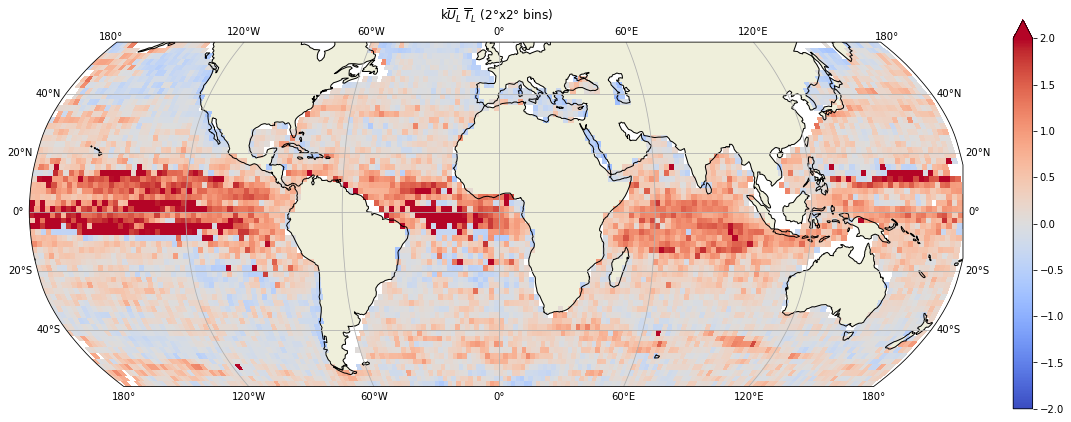

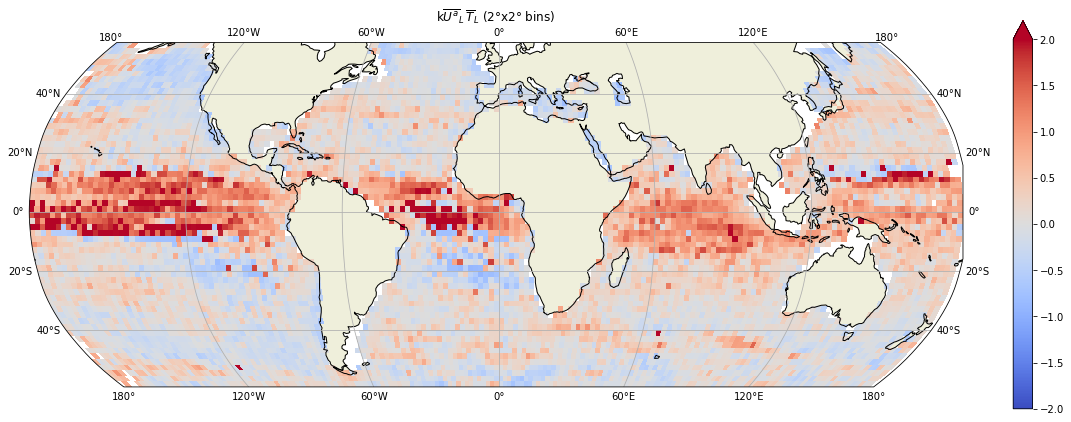

In [33]:
figsize=(15,6)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Ulbar*Tlbar_mean0*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kUT_mean0.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Ulbar_bis*Tlbar_mean0*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U^a}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kUT_mean1.png',bbox_inches='tight')




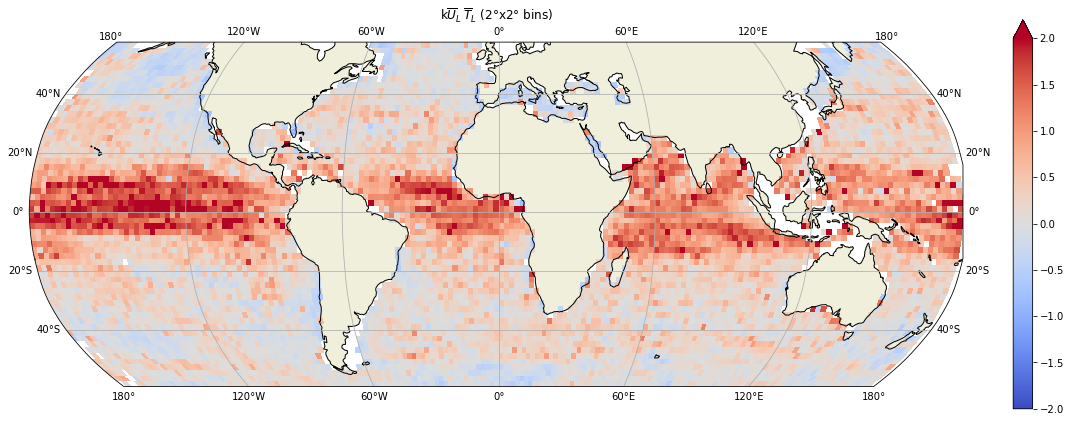

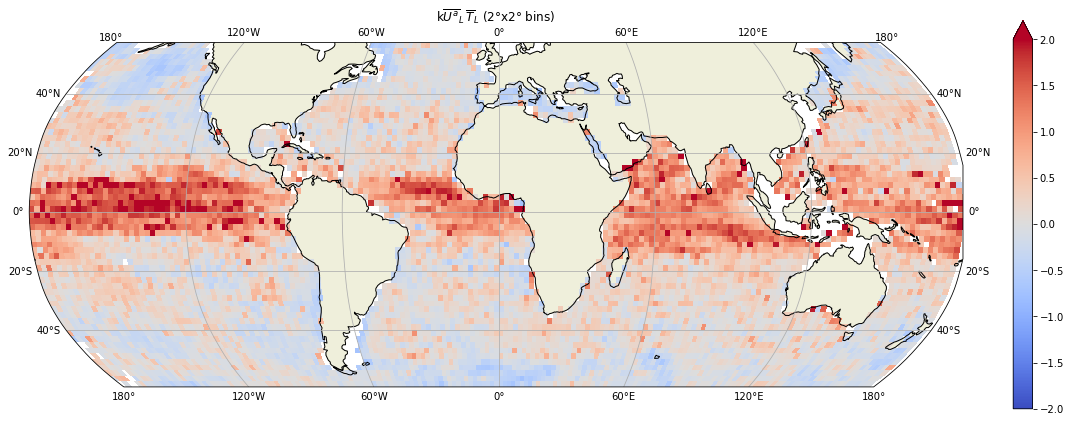

In [32]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Ulbar*Tlbar_mean1*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kUT_mean1.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Ulbar_bis*Tlbar_mean1*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U^a}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kUT_mean1.png',bbox_inches='tight')

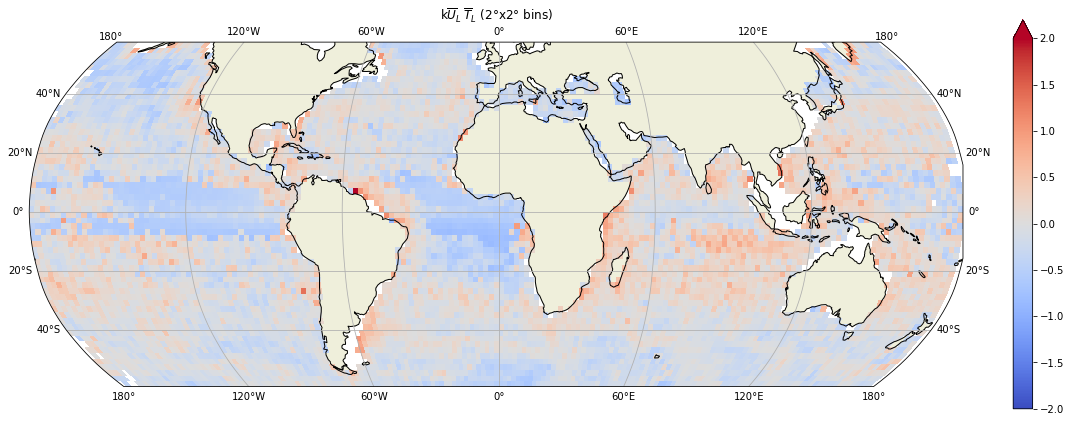

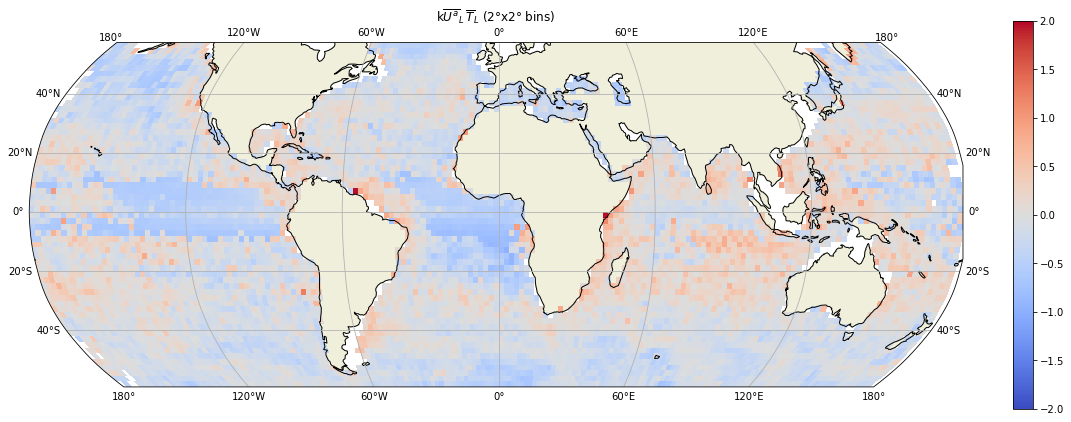

In [34]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Vlbar*Tlbar_mean0_V*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kVT_mean0.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Vlbar_bis*Tlbar_mean0_V*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U^a}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kUT_mean1.png',bbox_inches='tight')



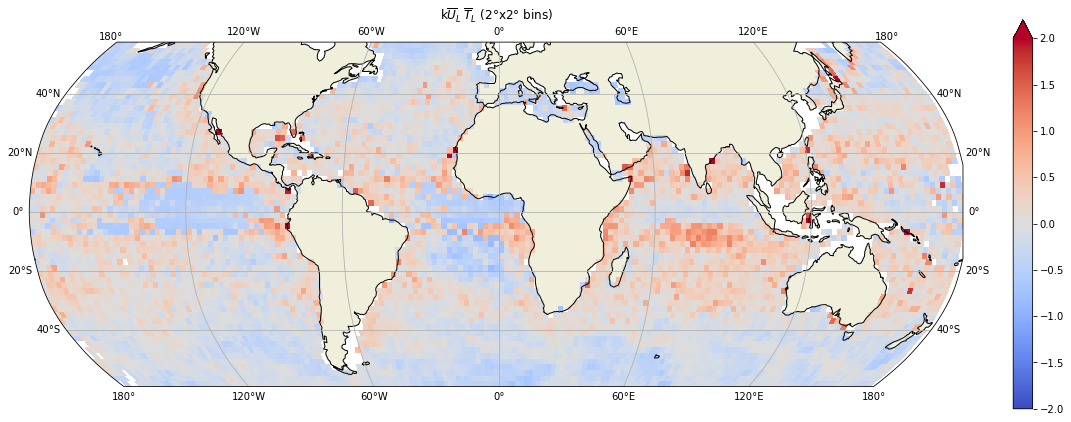

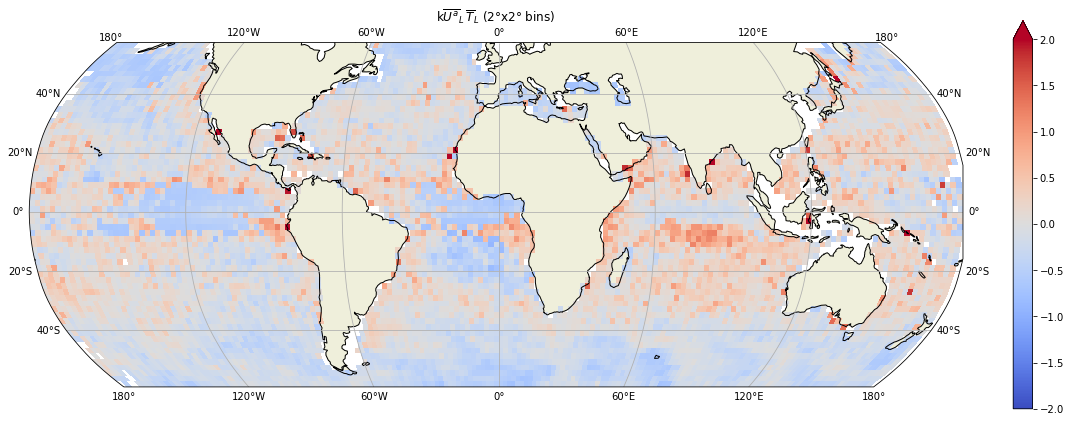

In [35]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Vlbar*Tlbar_mean1_V*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kVT_mean1.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Vlbar_bis*Tlbar_mean1_V*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U^a}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kUT_mean1.png',bbox_inches='tight')




In [36]:
contamination = lambda ds : 4*ds['domega']/(np.pi*ds['omega']**2*ds['T'])

In [37]:
T = dsL_low_mean0.sel(param='T').parameters_SSU
Tv = dsL_low_mean0.sel(param='T').parameters_SSV
U = ds_low.L_energy_SSU
V = ds_low.L_energy_SSV

domega = 0.2
_omega = omega

In [38]:
ds_contamination = xr.Dataset({'omega':_omega,'domega':domega,'T':T})
dsV_contamination = xr.Dataset({'omega':_omega,'domega':domega,'T':Tv})

In [39]:
_ds = contamination(ds_contamination)
_dsV = contamination(dsV_contamination)


Text(0.5, 1.0, '$4d\\omega/(\\pi\\omega^2\\bar T_L)$ (2°x2° bins)')

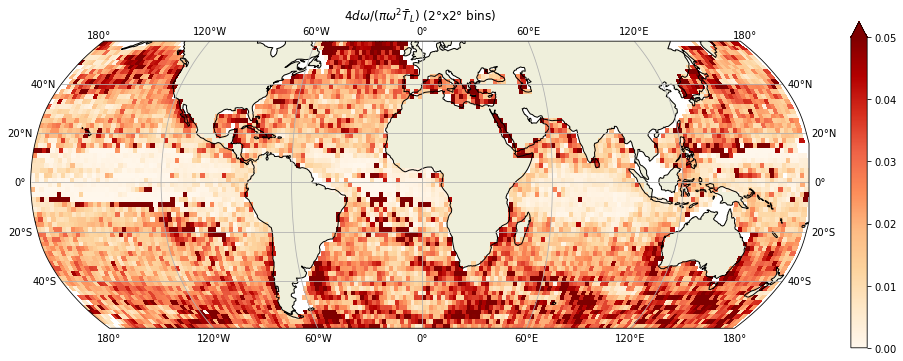

In [40]:
cmap='OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(_ds,vlim=(0,0.05),colmap=cmap)
ax.set_title(r'$4d\omega/(\pi\omega^2\bar T_L)$ (2°x2° bins)')
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lf_contamination_mean1.png')

Text(0.5, 1.0, '$4d\\omega/(\\pi\\omega^2\\bar T_L)$ (2°x2° bins)')

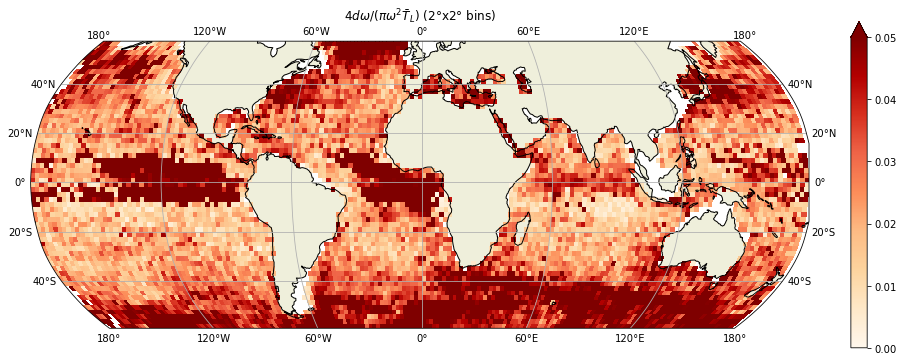

In [41]:
cmap='OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(_dsV,vlim=(0,0.05),colmap=cmap)
ax.set_title(r'$4d\omega/(\pi\omega^2\bar T_L)$ (2°x2° bins)')
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lf_contamination_SSV_mean1.png')

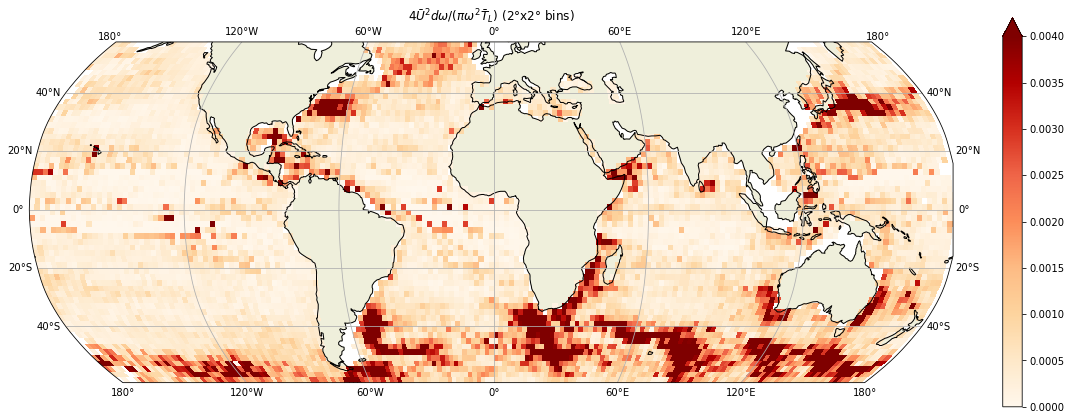

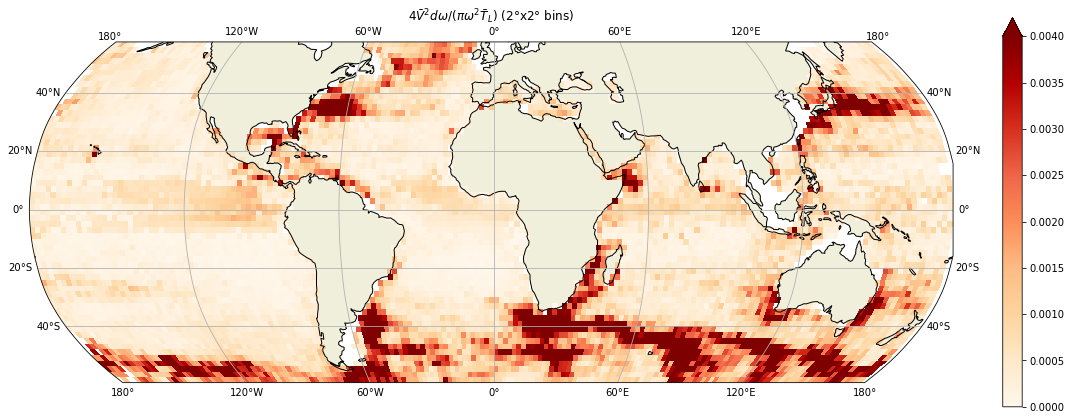

In [47]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(_ds*U,vlim=(0,0.004),colmap=cmap)
ax.set_title(r'$4\bar U^2d\omega/(\pi\omega^2\bar T_L)$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lf_contamination_mean0.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(_dsV*V,vlim=(0,0.004),colmap=cmap)
ax.set_title(r'$4\bar V^2d\omega/(\pi\omega^2\bar T_L)$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lf_contamination_SSV_mean0.png',bbox_inches='tight')

Text(0.5, 1.0, '$4d\\omega\\tilde U/(\\pi\\omega^2\\bar T_L)$ (2°x2° bins)')

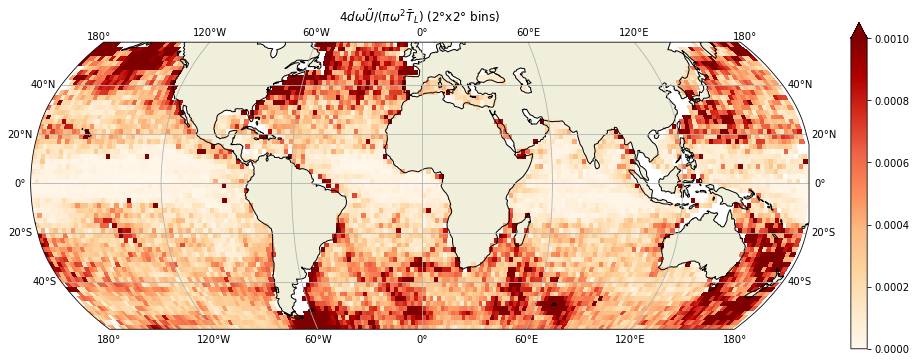

In [70]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(_ds*np.sqrt(hf_dl2.L_energy_SSU),vlim=(0,0.001),colmap=cmap)
ax.set_title(r'$4d\omega\tilde U/(\pi\omega^2\bar T_L)$ (2°x2° bins)')